In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

2025-02-28 01:44:50.771942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 01:44:50.970020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740678291.042326    1168 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740678291.062090    1168 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 01:44:51.232325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Check for GPU availability
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Background
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).
### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Data Inspection

In [4]:
# Import data
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
df["label"].unique()

array([0, 1])

Based on the data inspection, the id represents image tag while the label is a boolean value indicating whether the image contains cancer or not. The images are 96x96 pixels in size and are stored in the .tif format.
Therefore, this problem involves a simple binary classification problem where the goal is to classify whether the image contains cancer or not.

To evaluate the model, the area under the ROC curve will be used.

## Exploratory Data Analysis

In [ ]:
# Image sample size, for train/test data
print(len(os.listdir('histopathologic-cancer-detection/train')))
print(len(os.listdir('histopathologic-cancer-detection/test')))

220025
57458


In [ ]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

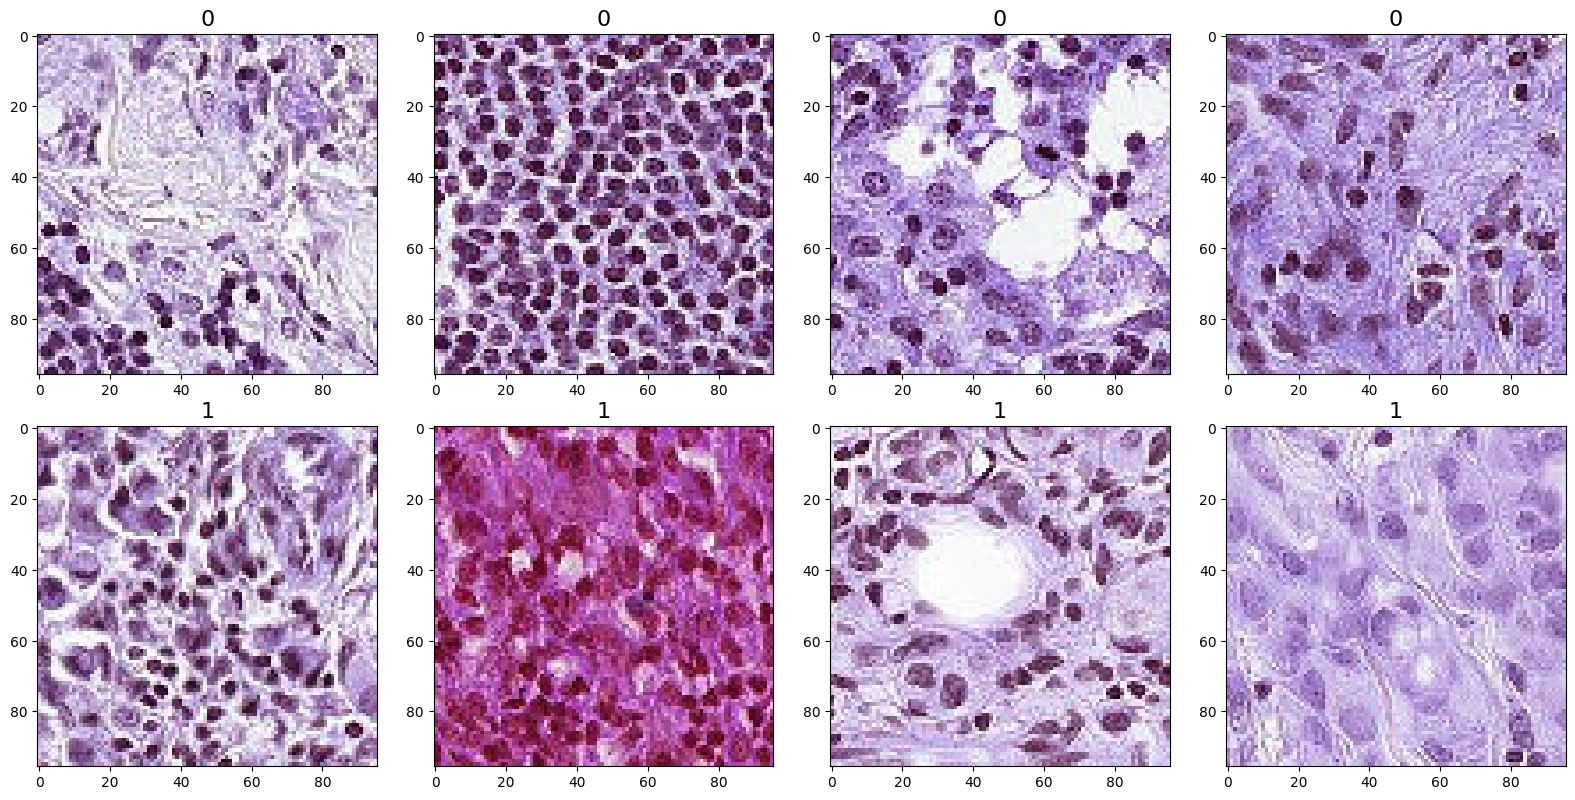

In [ ]:
# Sample images
IMAGE_PATH = 'histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df, IMAGE_PATH)

In [ ]:
# Check any missing data
print(df.isnull().sum())
# Check duplicated data
print(df.duplicated().sum())

id       0
label    0
dtype: int64
0


The data set for labels have no missing or duplicated values.

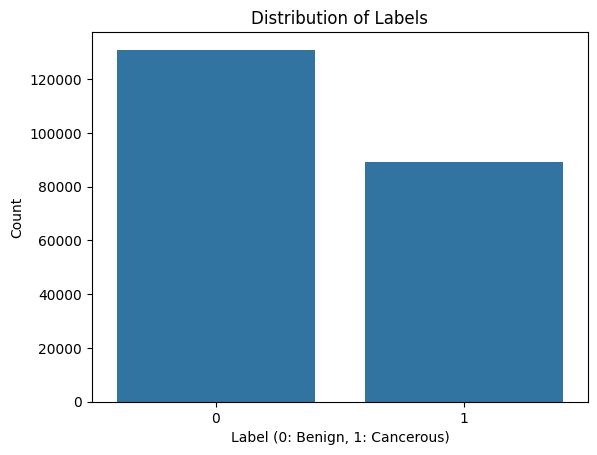

In [ ]:
# Plot distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Benign, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

From histogram, we can see there is no class imbalance in this dataset.

Based on the above, we can perform a simple binary classification model to classify whether the image contains cancer or not.

In [6]:
# Split data into train and test, by shuffling the data

df_0=df[df['label']==0].sample(80000, random_state=420)
df_1=df[df['label']==1].sample(80000, random_state=420)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df = shuffle(df)

df['label'].value_counts()

label
0    80000
1    80000
Name: count, dtype: int64

In [7]:
df_train, df_val = train_test_split(df, test_size=0.20, random_state=420, stratify=df['label'])

print(df_train.shape)
print(df_val.shape)

(128000, 2)
(32000, 2)


In [8]:
df.head()

,id,label
1450,7f198c974a371a74830abc84260a757d5fd2a151,0
70590,6ac3152599614c79481fd84fdc06e4c8020a1a22,0
39723,af47808fdbcbfca5eb396f0b8dba901f4b171082,0
5853,7e107952da2d6bd5b7310119366f4bebc65765c3,0
123680,ef50a68fba9f191a19082663aef3694e5e8aa9e4,1


In [9]:
df.set_index('id', inplace=True)

## Model Architecture

The model architecture will be a simple CNN model with the following layers:
- Conv2D layer with 32 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 64 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Conv2D layer with 128 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Flatten layer
- Dense layer with 128 units and ReLU activation function
- Dense layer with 1 unit and sigmoid activation function

The model will be compiled with the binary crossentropy loss function and the Adam optimizer.

The architecture is suitable for the problem because:

1. Convolutional Layers: These layers are effective in capturing spatial hierarchies in images. By stacking multiple convolutional layers, the model can learn complex features at different levels of abstraction.
2. Batch Normalization: This helps in stabilizing and accelerating the training process by normalizing the inputs of each layer. It can also act as a regularizer.
3. Dropout Layers: These layers help in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training time.
4. Dense Layers: These layers are used for classification. The final dense layer with a softmax activation function outputs probabilities for each class.


In [10]:
IMAGE_SIZE=96
IMAGE_CHANNELS=3

def cnn_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

model = cnn_model()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740678347.451957    1168 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Image Preparation

Created directory for image data for classifying whether the image contains cancer or not. Transfer images into them.

In [ ]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/train_dir/', label, fname)

    shutil.copyfile(src, dst)

for image in val_list:
    fname = image + '.tif'
    target = df.loc[image,'label']
    if target == 1:
        label = 'true'
    if target == 0:
        label = 'false'
    src = os.path.join('histopathologic-cancer-detection/train', fname)
    dst = os.path.join('histopathologic-cancer-detection/val_dir/', label, fname)

    shutil.copyfile(src, dst)

In [11]:
# Check how many images are in the train_dir
print(len(os.listdir('histopathologic-cancer-detection/train_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/train_dir/false')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/true')))
print(len(os.listdir('histopathologic-cancer-detection/val_dir/false')))

64000
64000
16000
16000


In [12]:
train_path = 'histopathologic-cancer-detection/train_dir'
valid_path = 'histopathologic-cancer-detection/val_dir'
test_path = 'histopathologic-cancer-detection/test'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = int(np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [13]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 128000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


## Model Training

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
val_gen.class_indices

{'false': 0, 'true': 1}

In [16]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740678392.579133   11243 service.cc:148] XLA service 0x7f71900178c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740678392.579462   11243 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-28 01:46:32.626690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740678392.860150   11243 cuda_dnn.cc:529] Loaded cuDNN version 90300


   10/12800 ━━━━━━━━━━━━━━━━━━━━ 2:50 13ms/step - accuracy: 0.4084 - loss: 1.1260 

I0000 00:00:1740678396.518674   11243 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12800/12800 ━━━━━━━━━━━━━━━━━━━━ 187s 14ms/step - accuracy: 0.7579 - loss: 0.5125 - val_accuracy: 0.8203 - val_loss: 0.4002
Epoch 2/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 157s 12ms/step - accuracy: 0.8327 - loss: 0.3908 - val_accuracy: 0.8093 - val_loss: 0.4423
Epoch 3/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 147s 11ms/step - accuracy: 0.8416 - loss: 0.3678 - val_accuracy: 0.8526 - val_loss: 0.3436
Epoch 4/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 153s 12ms/step - accuracy: 0.8509 - loss: 0.3525 - val_accuracy: 0.8679 - val_loss: 0.3209
Epoch 5/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 148s 12ms/step - accuracy: 0.8562 - loss: 0.3442 - val_accuracy: 0.8696 - val_loss: 0.3217
Epoch 6/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 147s 11ms/step - accuracy: 0.8559 - loss: 0.3426 - val_accuracy: 0.8593 - val_loss: 0.3407
Epoch 7/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step - accuracy: 0.8602 - loss: 0.3356 - val_accuracy: 0.8668 - val_loss: 0.3332
Epoch 8/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 126s 10ms/step - accur

## Model Evaluation

In [17]:
model.metrics_names

['loss', 'compile_metrics']

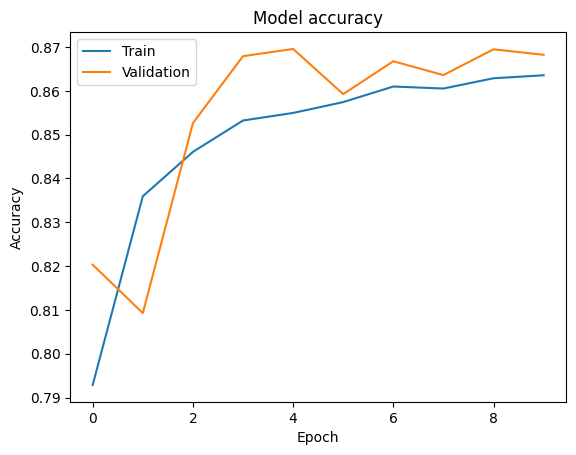

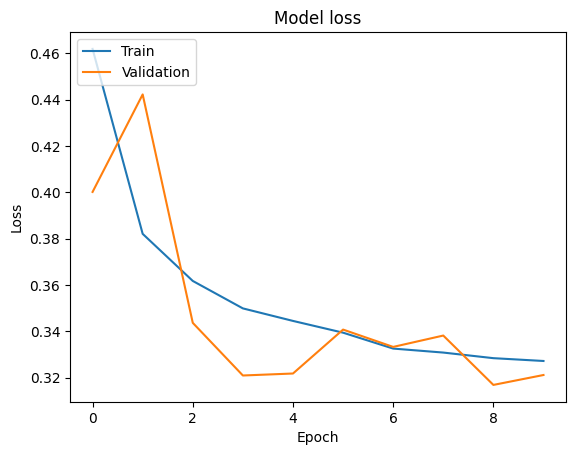

In [18]:
# Evaluation Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

From the model accuracy and model loss plot, we can see that the model is performing well on the training data. With increasing epochs, the model accuracy is increasing and the model loss is decreasing. 

However, at higher epoch for validation data, the line is fluctuating. This indicates that the model is at slight risk of overfitting.

In [19]:
# Prediction

predictions = model.predict(test_gen, steps=len(df_val), verbose=1)
df_preds = pd.DataFrame(predictions, columns=['false', 'true'])
y_true = test_gen.classes
y_pred = df_preds['true']
y_pred

32000/32000 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step


0        0.001055
1        0.000093
2        0.000961
3        0.006907
4        0.558163
           ...   
31995    0.998817
31996    1.000000
31997    0.999995
31998    0.132534
31999    0.003322
Name: true, Length: 32000, dtype: float32

In [20]:
roc_auc_score(y_true, y_pred)

np.float64(0.9472493769531252)

A 94% score was achieved on the test set. The model was able to classify whether the image contains cancer or not with a high accuracy.

In [21]:
confusion_matrix(test_gen.classes, predictions.argmax(axis=1))

array([[13151,  2849],
       [ 1368, 14632]])

<Axes: >

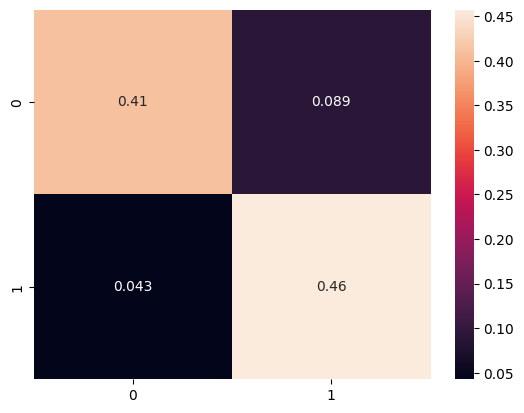

In [22]:
sns.heatmap(confusion_matrix(test_gen.classes, predictions.argmax(axis=1))/len(predictions), annot=True)

From the confusion matrix plot, we can see that the model is performing well on the test data. The model is able to classify images with cancer and without cancer with high accuracy.

## Model turning
- Adding more convolutional layers: This can help the model learn more complex features from the images.

In [ ]:
def cnn_model_more_layers():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

model_more_layers = cnn_model_more_layers()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_more_layers.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,978 (4.09 MB)

 Trainable params: 1,070,978 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_more_layers.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_more_layers = model_more_layers.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 185s 14ms/step - accuracy: 0.4978 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
12800/12800 ━━━━━━━━━━━━━━━━━━━━ 411s 32ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
11496/12800 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.4978 - loss: 0.6932

KeyboardInterrupt: 

## Prediction with test data

In [23]:
test_list = os.listdir('histopathologic-cancer-detection/test')

for image in test_list:
    fname = image
    src = os.path.join('histopathologic-cancer-detection/test', fname)
    dst = os.path.join('histopathologic-cancer-detection/test_dir/temp', fname)
    shutil.copyfile(src, dst)

In [24]:
test_gen = datagen.flow_from_directory('histopathologic-cancer-detection/test_dir',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [25]:
predictions = model.predict(test_gen, steps=57458, verbose=1)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step


In [26]:
df_pred = pd.DataFrame(predictions, columns=['True', 'False'])
df_pred['id'] = test_list
df_pred['id'] = df_pred['id'].apply(lambda x: x.split('.')[0])
df_pred['label'] = df_pred['True']
df_pred = df_pred[['id', 'label']].set_index('id')
df_pred.head()

,label
id,
684472faba7fdff8ac94687b84521b6c99467423,0.000318
4b2b924ac8ed8757728dece231fef9090c26dd18,0.008292
b6857075ab9f6bbdd6801886e94b9a452f2c1e83,0.403575
159d539ecc494bad107a7ec9ac52b750b10c065e,0.919040
5ec3929919ba08ce75cb9f5b5fd00e4120587998,0.990695


In [27]:
# Submission
df_pred.to_csv('submission.csv')